# Fourier analysis with Python


In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
from astropy.timeseries import LombScargle
def LSWrapper(x, y, oversampling=1, freqMin=None, freqMax=None, freq=None, return_val="power"):
    """
    Calculate the power spectrum density for a discrete time series.
    https://en.wikipedia.org/wiki/Spectral_density


    Input:
    x: array-like[N,]
        The time array.

    y: array-like[N,]
        The flux array.


    Optional input:
    oversampling: float, default: 1
        The oversampling factor to control the frequency grid.
        The larger the number, the denser the grid.

    freqMin: float, default: frequency resolution

    freqMax: float, default: nyquist frequency

    freq: array-like[M, ], default: np.arange(freqMin, freqMax, dfreq/oversampling)
        frequencies at which the power spectrum is desired to estimate.
        does not function if  ``return_val'' set to ``window''.

    return_val: str, default: power
        one of ``psd_old'', ``periodogram'', ``power'', ``amplitude'', ``psd'', ``window''

    Output:
    freq: np.array
        frequency, in unit of [x]^-1.

    p: np.array
        power spectrum, depending on ``return_val''.
        ``power'': power spectrum in unit of [y]^2 (default)
        ``amplitude'': amplitude spectrum in unit of [y]
        ``psd'': power spectrum density in unit of [y]^2/[x] (more favored)
        ``psd_old'': power spectrum density in unit of [y]^2/[x]
        ``periodogram'': periodogram
        ``window'': power spectrum of the window function, i.e. spectral window

    Examples:
    >>> ts = np.load("flux.npy")
    >>> t = ts["time_d"]   # the time in day
    >>> f = ts["flux_mf"]   # the relative flux fluctuated around 1
    >>> f = (f-1)*1e6   # units, from 1 to parts per million (ppm)

    >>> freq, psd = se.psd(t, f, return_val="psd_new")
    >>> freq = freq/(24*3600)*1e6   # c/d to muHz
    >>> psd = psd*(24*3600)*1e-6   # ppm^2/(c/d) to ppm^2/muHz

    """

    if not (return_val in ["psd_old", "periodogram", "power", "amplitude", "psd", "window"]):
        raise ValueError("return_val should be one of ['psd_old', 'periodogram', 'power', 'amplitude', 'psd', 'window'] ")

    Nx = len(x)
    dx = np.median(x[1:]-x[:-1]) 
    fs = 1.0/dx
    # Tobs = dx*len(x)
    fnyq = 0.5*fs
    dfreq = fs/Nx

    if freqMin is None: freqMin = dfreq
    if freqMax is None: freqMax = fnyq

    if freq is None: freq = np.arange(freqMin, freqMax, dfreq/oversampling)
	
    if return_val == "psd_old":
        p = LombScargle(x, y).power(freq, normalization='psd')*dx*4.
    if return_val == "periodogram":
        p = LombScargle(x, y).power(freq, normalization='psd')
    if return_val == "power":
        p = LombScargle(x, y).power(freq, normalization='psd')/Nx*4.
    if return_val == "amplitude":
        p = np.sqrt(LombScargle(x, y).power(freq, normalization='psd')/Nx*4.)
    if return_val == "psd":
        nu = 0.5*(freqMin+freqMax)
        freq_window = np.arange(freqMin, freqMax, dfreq/10) 
        power_window = LombScargle(x, np.sin(2*np.pi*nu*x)).power(freq_window, normalization="psd")/Nx*4.
        Tobs = 1.0/np.sum(np.median(freq_window[1:]-freq_window[:-1])*power_window)
        p = (LombScargle(x, y).power(freq, normalization='psd')/Nx*4.)*Tobs
    if return_val == "window":
        nu = 0.5*(freqMin+freqMax)
        freq_window = np.arange(freqMin, freqMax, dfreq/10)
        power_window = LombScargle(x, np.sin(2*np.pi*nu*x)).power(freq_window, normalization="psd")/Nx*4.
        freq, p = freq_window-nu, power_window

    return freq, p

# Let's recap Fourier transform

The following information is largely copied from C. Aerts, J. Christensen-Dalsgaard, D. W. Kurtz (2010, Chapter 5, page 354). If you are interested in understanding e.g. prewhitening, window function, fourier transform, and various spectral analysis method in astrophyics context, I strongly recommend advising this book.

Given a time series $x(t_i)$ known for a discrete number of time points $t_i$, $i=1, ..., N$. The discrete Fourier transform is defined as

$$F_N(\nu) = \sum_{i=1}^{N} x(t_i) \exp(2\pi i \nu t_i).$$

When we only care about how strong the signal at a certain frequency is, we convert it into periodogram, which loses the phase information:

$$P_N(\nu) = \frac{1}{N} \left|F_N(\nu)\right|^2 = \frac{1}{N} \left|\sum_{i=1}^{N} x(t_i) \exp(2\pi i \nu t_i)\right|^2 = \frac{1}{N}\left\{ \left( \sum_{i=1}^{N} x(t_i)\sin(2\pi\nu t_i) \right)^2  + \left( \sum_{i=1}^{N} x(t_i)\cos(2\pi\nu t_i) \right)^2 \right\} .$$

If the signal we are searching is a pure harmonic one of the form $x(t_i) = A\cos(2\pi\nu_1 t_i)$, the periodogram will have the value

$$ P_N(\nu_1) =\frac{1}{N}\left\{ \left( \sum_{i=1}^{N} A\cos(2\pi\nu_1 t_i) \sin(2\pi\nu_1 t_i) \right)^2  + \left( \sum_{i=1}^{N} A\cos(2\pi\nu_1 t_i) \cos(2\pi\nu_1 t_i) \right)^2 \right\}. $$

For large $N$ we have

$$ \sum_{i=1}^{N} A\cos(2\pi\nu_1 t_i) \sin(2\pi\nu_1 t_i) \approx 0, $$
$$ \sum_{i=1}^{N} A\cos(2\pi\nu_1 t_i) \cos(2\pi\nu_1 t_i) \approx AN/2. $$

So $P_N(\nu_1) \approx A^2N/4$ for large $N$. The periodogram $P_N(\nu)$ is less desirable to use because it depends on the number of data points $N$. We usually consider the amplitude spectrum, where the height of a peak gives the true amplitude of that sine-wave component in time series, i.e.

$$ A(\nu) = \sqrt{\frac{4P_N(\nu)}{N}}.$$

We would hence refer to the power spectrum as $A^2$. After all, that is what we want to interpret in terms of astrophyical signal. Another quantity used widely in literature is the power spectrum density, which is the power spectrum per frequency:
$$ S_N(\nu) =  T A^2(\nu). $$
where $T = N\Delta t$.
A statiscally driven and damped oscillator often has decreasing amplitude in the amplitude spectrum when observations $T$ get longer. Transforming to $S_N(\nu)$ could fix its height while the noise level varies. 

# What's the difference in ``return_vals``?

The function ``LSWrapper`` wraps the class ``LombScargle`` from ``astropy``. If set normilization method to ``normilization="psd"``, ``LombScargle`` will return the periodogram, which is sometimes confusing. The function ``LSWrapper`` returns the following: 

1. "amplitude": $A$
2. "power": $A^2$
3. "periodogram": $P_N$
4. "psd_old": $S_N$ determined by simply multiplying $P$ with $\Delta t$, which can be incorrect if the data has weird sampling.
5. "psd": $S_N$ determined by multiplying $A^2$ with $T$, which was calculated from integrating a spectral window (see the Appendix A of Kjeldsen & Bedding, 1995, A&A, vol 293, p87). 


# Power spectrum and amplitude spectrum
## Good data: evenly sampled

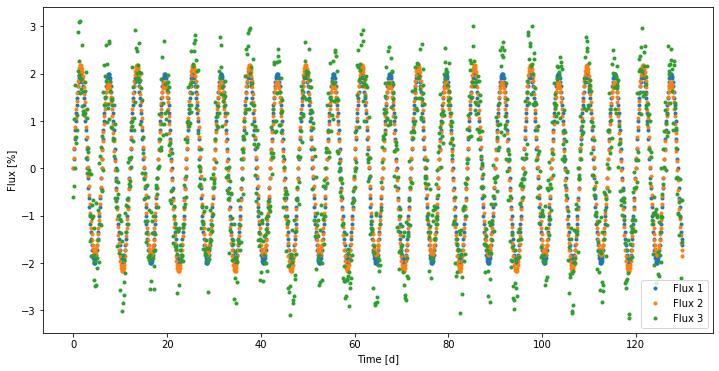

In [3]:
t = np.arange(0,130,0.1)
flux1 = 2*np.sin(2*np.pi*t/6)
flux2 = 2*np.sin(2*np.pi*t/6) + 0.25*np.sin(2*np.pi*t/12)
flux3 = 2*np.sin(2*np.pi*t/6) + 0.25*np.sin(2*np.pi*t/12) + 0.1*np.sin(2*np.pi*t/24) + (np.random.rand(t.shape[0])-0.5)*2.
flux = [flux1, flux2, flux3]

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(t, flux1, ".", label="Flux 1")
ax.plot(t, flux2, ".", label="Flux 2")
ax.plot(t, flux3, ".", label="Flux 3")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Flux [%]")
ax.legend()

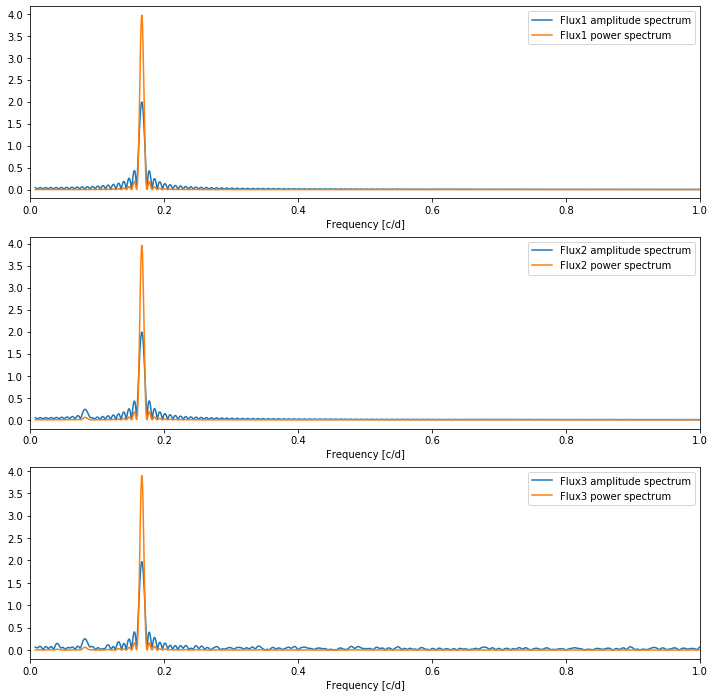

In [4]:
fig = plt.figure(figsize=(12,12))
ax = fig.subplots(nrows=3, ncols=1)

for iax in range(3):
    freq, amp = LSWrapper(t, flux[iax], oversampling=10, return_val="amplitude")
    freq, power = LSWrapper(t, flux[iax], oversampling=10, return_val="power")
    ax[iax].plot(freq, amp, label="Flux{:0.0f} amplitude spectrum".format(iax+1))
    ax[iax].plot(freq, power, label="Flux{:0.0f} power spectrum".format(iax+1))
    ax[iax].set_xlim(0, 1)
    ax[iax].set_xlabel("Frequency [c/d]")
    ax[iax].legend()


## Unvenly sampled data

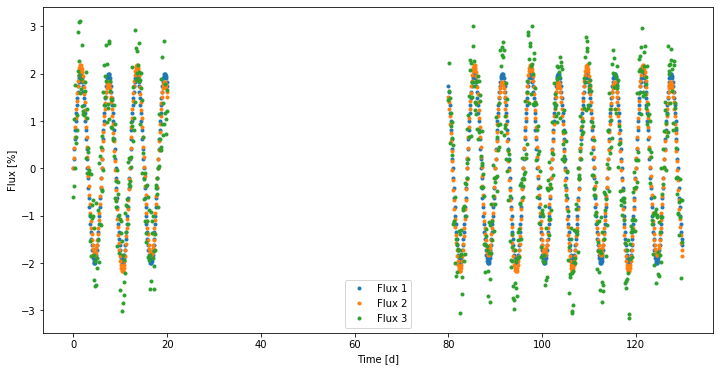

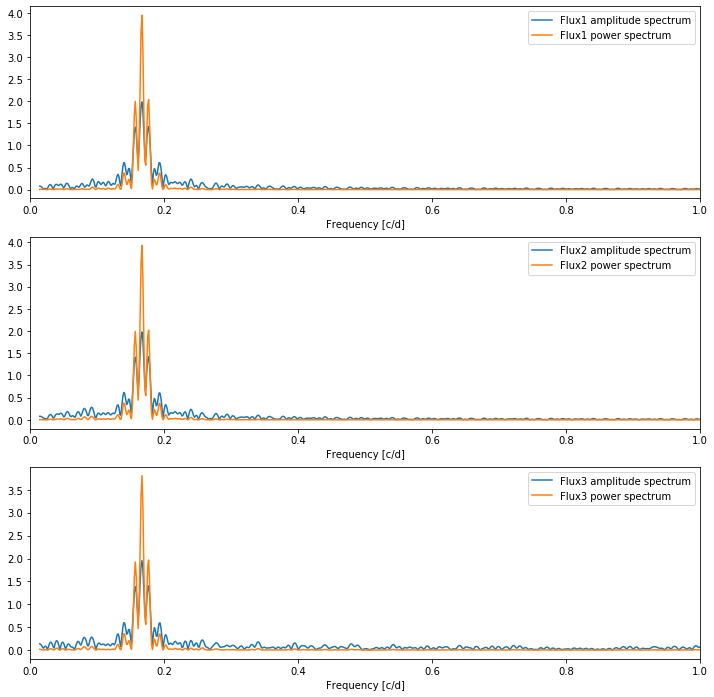

In [5]:
idx = ~((t>20) & (t<80))

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(t[idx], flux1[idx], ".", label="Flux 1")
ax.plot(t[idx], flux2[idx], ".", label="Flux 2")
ax.plot(t[idx], flux3[idx], ".", label="Flux 3")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Flux [%]")
ax.legend()

fig = plt.figure(figsize=(12,12))
ax = fig.subplots(nrows=3, ncols=1)
for iax in range(3):
    freq, amp = LSWrapper(t[idx], flux[iax][idx], oversampling=10, return_val="amplitude")
    freq, power = LSWrapper(t[idx], flux[iax][idx], oversampling=10, return_val="power")
    ax[iax].plot(freq, amp, label="Flux{:0.0f} amplitude spectrum".format(iax+1))
    ax[iax].plot(freq, power, label="Flux{:0.0f} power spectrum".format(iax+1))
    ax[iax].set_xlim(0, 1)
    ax[iax].set_xlabel("Frequency [c/d]")
    ax[iax].legend()


We can see the height on the amplitude spectrum is still equal to 1 even for unevenly sampled data, but the shape of the peaks gets nasty.

Now let's simulate what data looks like from ground-based observations, i.e. with regular gaps ~ 0.5 day.

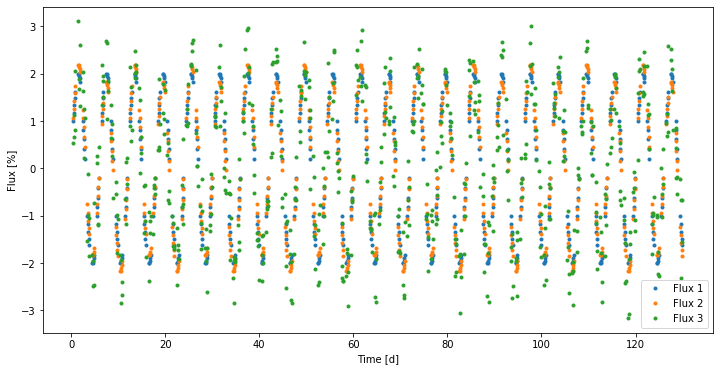

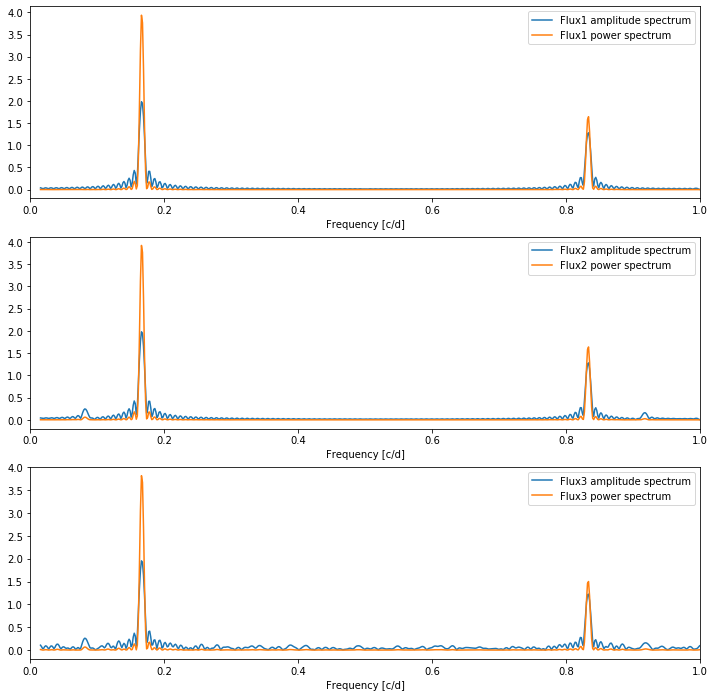

In [6]:
idx = np.ones(t.shape[0], dtype=bool)
tstart = 0.
while tstart <= np.max(t):
    idx[((t>=tstart) & (t<tstart+0.5))] = False
    tstart += 1.

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(t[idx], flux1[idx], ".", label="Flux 1")
ax.plot(t[idx], flux2[idx], ".", label="Flux 2")
ax.plot(t[idx], flux3[idx], ".", label="Flux 3")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Flux [%]")
ax.legend()

fig = plt.figure(figsize=(12,12))
ax = fig.subplots(nrows=3, ncols=1)
for iax in range(3):
    freq, amp = LSWrapper(t[idx], flux[iax][idx], oversampling=10, return_val="amplitude")
    freq, power = LSWrapper(t[idx], flux[iax][idx], oversampling=10, return_val="power")
    ax[iax].plot(freq, amp, label="Flux{:0.0f} amplitude spectrum".format(iax+1))
    ax[iax].plot(freq, power, label="Flux{:0.0f} power spectrum".format(iax+1))
    ax[iax].set_xlim(0, 1)
    ax[iax].set_xlabel("Frequency [c/d]")
    ax[iax].legend()

We can see that the regular gaps introduce funny sidelobes. If we don't have prior knowledge to guide through identification, it's hard to make inference from data observed on ground, espcially for period around 1 day.